## Brief description of the problem and data
Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science.<br>
A GAN consists of at least two neural networks: a generator model and a discriminator model. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images. The task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

### Git Repo
Link: https://github.com/Lenni-A/Deep_Learning/tree/main/week5

### Data
Source data: https://www.kaggle.com/competitions/gan-getting-started/data

**Files**<br>
- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format<br>
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format<br>
- photo_jpg - 7028 photos sized 256x256 in JPEG format<br>
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format<br>

### Kaggle Submission format
Your kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256.

In [1]:
import os
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, metrics, losses
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except Exception as e:
    print("Unable to initialize tpu, using default. Exception: " + str(e))
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE

Unable to initialize tpu, using default. Exception: Please provide a TPU Name to connect to.
Number of replicas: 1


In [3]:
monet_jpg_path = './data/monet_jpg/'
monet_tfrec_path = './data/monet_tfrec/'
photo_jpg_path = './data/photo_jpg/'
photo_tfrec_path = './data/photo_tfrec/'
monet_jpeg_files = tf.io.gfile.glob(monet_jpg_path + '*.jpg')
monet_tfrec_files = tf.io.gfile.glob(monet_tfrec_path + '*.tfrec')
photo_jpeg_files = tf.io.gfile.glob(photo_jpg_path + '*.jpg')
photo_tfrec_files = tf.io.gfile.glob(photo_tfrec_path + '*.tfrec')
print('Monet JPG Files:', len(monet_jpeg_files))
print('Monet TFR Files:', len(monet_tfrec_files))
print('Photo JPG Files:', len(photo_jpeg_files))
print('Photo TFR Files:', len(photo_tfrec_files))

# Create dataset cointaing the labeled images.
img_size = [256, 256]
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.reshape(image, [*img_size, 3])
    return image

def read_tfrecord(images):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    si = tf.io.parse_single_example(images, tfrecord_format)
    image = decode_image(si['image'])
    return image

def create_dataset(filenames):
    ds = tf.data.TFRecordDataset(filenames)
    ds = ds.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return ds

ds_monet = create_dataset(monet_tfrec_files).batch(32)

Monet JPG Files: 300
Monet TFR Files: 5
Photo JPG Files: 7038
Photo TFR Files: 20


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
Show a few visualizations like histograms. Describe any data cleaning procedures.

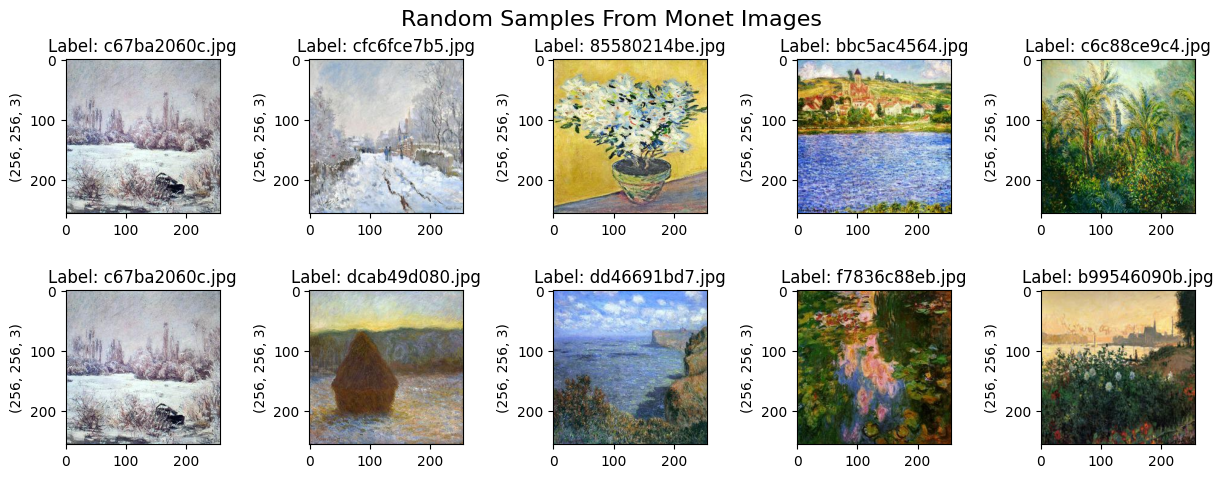

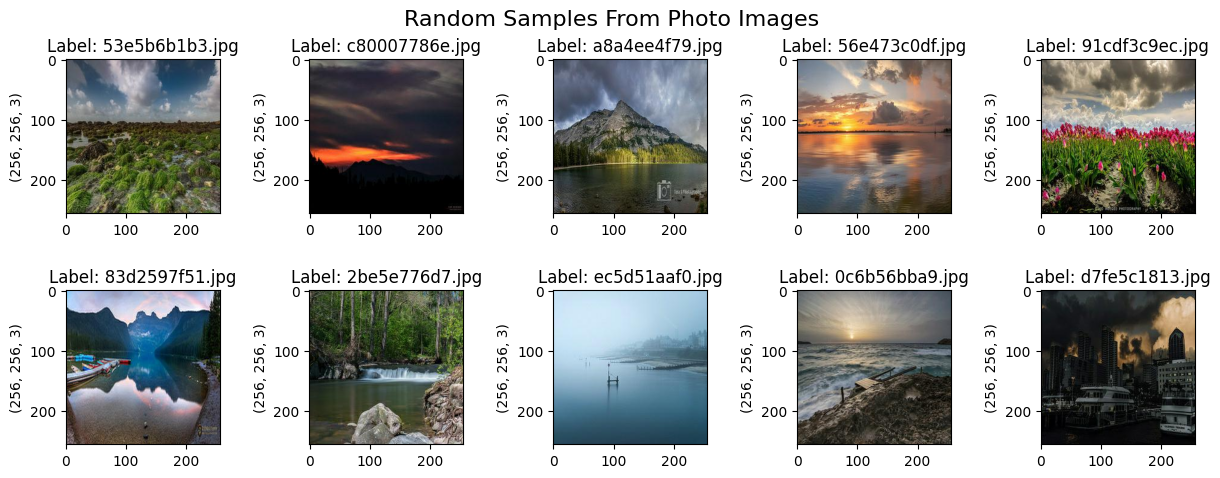

In [4]:
# Show random samples from training data.
def show_random_images(img_path:str, sub_title:str):
    img_cnt = 10
    fig, axs = plt.subplots(2, img_cnt // 2, figsize=(15, 5), gridspec_kw={'wspace': 0.3, 'hspace': 0.5})
    train_imgs = os.listdir(img_path)
    for ax in axs.ravel():
        file_img = np.random.choice(train_imgs)
        img = image.imread(os.path.join(img_path, file_img))
        ax.imshow(img)
        ax.set_title(f'Label: {file_img}')
        ax.set_ylabel(img.shape)
    plt.suptitle(f'Random Samples From {sub_title}', fontsize=16)
    plt.show()

show_random_images(monet_jpg_path, 'Monet Images')
show_random_images(photo_jpg_path, 'Photo Images')

## DModel Architecture
Describe model architecture and reasoning for why that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

### Create Model
Use DCGAN which is very suitable for image generating task. For both generator and discriminator, after trying out differen compositions (from 1 to 5), a hidden layer of 4 turns out sufficient enough to capture different levels of abstraction and allows the model to learn and represent a diverse set of features. The generator architecture consists of a series of transposed convolutional layers with increasing dimensions which starts from a dense layer with 256 units. It gradually upsamples the input noise into a 256 x 256 x 3 image. The discriminator follows a typical convolutional neural network architecture with convolutional layers, batch normalization, and leaky ReLU activations. It downsamples the input image, extracts hierarchical features, and ends with a dense layer for binary classification. The use of batch normalization in the discriminator helps stabilize and accelerate training by normalizing the inputs to each layer. 

In [5]:
def create_generator(name:str, h_layers:int = 4, dim_shape:int = 16, filter_count:int = 256):
    activation_sig = 'sigmoid'
    activation_tanh = 'tanh'
    kernel_size = (3,3)
    h_strides= (2,2)
    o_strides = (1,1)
    relu_alpha = 0.2
    output_filter_count = 3
    depth_unit = 256

    model = Sequential(name=name)
    # Define dense connection. Input / First layer
    model.add(Dense(dim_shape * dim_shape, input_shape=(dim_shape, dim_shape, depth_unit)))
    # Is used to change the shape of the input.
    model.add(Reshape((dim_shape, dim_shape, depth_unit)))
    filter_count = filter_count
    # Create hidden layers
    for i in range(h_layers):
        model.add(Conv2DTranspose(filter_count, kernel_size, strides=h_strides, padding='same'))
        # alpha = slope of the activation
        model.add(LeakyReLU(alpha=relu_alpha))
        filter_count /= 2

    model.add(Conv2DTranspose(output_filter_count, kernel_size=(3, 3), activation=activation_tanh, strides=o_strides, padding='same'))
    return model

def create_discriminator(name:str, h_layers:int = 4, dim_shape:int = 256, filter_count:int = 64):
    activation_sig = 'sigmoid'
    activation_tanh = 'tanh'
    kernel_size = (3,3)
    h_strides= (2,2)
    relu_alpha = 0.2
    dim_shape_depth = 3
    dropout = 0.3

    model = Sequential(name=name)
    # Define convuluted layer. Input / First layer
    model.add(Conv2D(filters=filter_count/2, kernel_size=kernel_size, strides=h_strides, padding='same', input_shape=[dim_shape, dim_shape, dim_shape_depth]))
    model.add(LeakyReLU(alpha=relu_alpha))
    filter_count = filter_count
    # Create hidden layers
    for i in range(h_layers):
        model.add(Conv2D(filters=filter_count, kernel_size=kernel_size, strides=h_strides, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=relu_alpha))
        filter_count *= 2

    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation=activation_sig))
    return model

class GAN(Model):
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_opt = d_optimizer
        self.g_opt = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        gen_images = self.generator(tf.random.normal(((1, 16, 16, 256))), training=True)
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            pred_real = self.discriminator(real_images, training=True)
            pred_gen  = self.discriminator(gen_images, training=True)
            pred_real_gen = tf.concat([pred_real, pred_gen], axis=0)
            y_real_gen = tf.concat([tf.zeros_like(pred_real), tf.ones_like(pred_gen)], axis=0)
            noise_real = 0.15 * tf.random.uniform(tf.shape(pred_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(pred_gen))
            y_real_gen += tf.concat([noise_real, noise_fake], axis=0)
            d_loss = self.loss_fn(y_real_gen, pred_real_gen)
            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))        
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal(((1, 16, 16, 256))), training=True)
            pred_gen  = self.discriminator(gen_images, training=False)
            g_loss = self.loss_fn(tf.zeros_like(pred_gen), pred_gen)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_weights))
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": d_loss, "g_loss": g_loss}


Create and train a model with starting configuration which will be optimized in the later section. Use BCE loss to measure the binary cross-entropy between the predicted probabilities and the actual labels, for the discriminator to correctly classify real images as real (label 1) or fake (label 0) and for generator the inverse classifications. Use Adam (Adaptive Moment Estimation) as optimizer which is not only popular choice for training GANs but more dynamic compared to standard SGD, as it incorporates the concept of momentum and adjusts the learning rates during training, providing a balance between quick convergence and avoiding overshooting.

In [6]:
### Set some base setup
# Layer count
h_layers = 4
# Generator filters: high -> low (start with image size)
gen_filters = 32
# Discriminator filters: low -> high
dis_filters = gen_filters / (2**(h_layers-1))

with strategy.scope():
    generator = create_generator('generator', h_layers=h_layers, filter_count=gen_filters)
generator.summary()

with strategy.scope():
    discriminator = create_discriminator('discriminator', h_layers=h_layers, filter_count=dis_filters)
discriminator.summary()

epochs = 10

gan = GAN(discriminator=discriminator, generator=generator)
gan.compile(
    d_optimizer = Adam(learning_rate=0.0001),
    g_optimizer = Adam(learning_rate=0.0001),
    loss_fn = losses.BinaryCrossentropy(),
)
model_trained = gan.fit(ds_monet, epochs=epochs)

### <-- Adhoc test start
# noise = tf.random.normal([1, batch_size])
# with strategy.scope():
#     gen_image = generator(noise, training=False)

# Show generated image
# plt.figure(figsize=(3, 2))
# plt.imshow(generated_image[0,:,:,0])

# with strategy.scope():
#     dis_result = discriminator(gen_image)
# print(dis_result)
### Adhoc test end -->

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16, 16, 256)       65792     
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 32)       73760     
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 16)       4624      
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 16)        0 

## Results and Analysis
Based on the training output of DCGAN model which has 4 hidden layers using 32 (gen) /4 (dis) filters, the results show a decreasing discriminator loss and a decreasing but oscillating generator loss, indicating that the generator is learning to produce more realistic images but there might be room for improvement in stability.

### Fine tuning model
Run training using set of hyperparameters and fine the store the best model version.

In [8]:
best_d_loss = 0
model_trained = None

epochs = [50, 100, 200]
# Generator filters: high -> low (start with image size)
gen_filters = [64, 128, 256]

for i, epoch in enumerate(epochs):
    gen_filter = gen_filters[i]
    with strategy.scope():
        generator = create_generator('generator', filter_count=gen_filter)
    generator.summary()

    # Discriminator filters: low -> high
    dis_filters = gen_filter / (2**(h_layers-1))
    with strategy.scope():
        discriminator = create_discriminator('discriminator', filter_count=dis_filters)
    discriminator.summary()

    gan = GAN(discriminator=discriminator, generator=generator)
    gan.compile(
        d_optimizer = Adam(learning_rate=0.0001),
        g_optimizer = Adam(learning_rate=0.0001),
        loss_fn = losses.BinaryCrossentropy(),
    )
    mg = gan.fit(ds_monet, epochs=epoch)
    d_loss = np.mean(mg.history['d_loss'])
    print(f'MEAN DISCRIMNINATOR LOSS: {d_loss}')
    if d_loss > best_d_loss:
        best_d_loss = d_loss
        model_trained = mg

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16, 16, 256)       65792     
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 32, 32, 64)       147520    
 Transpose)                                                      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 64, 64, 32)       18464     
 Transpose)                                                      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 32)        0 

#### Post Analysis
Looking at the new execution loss values, the generator loss (g_loss) fluctuates significantly during training which could indicate that the generator struggles to consistently produce realistic images, that might be due to issues such as mode collapse or lack of diversity in generated samples. The discriminator loss (d_loss) shows some stability but the overall adversarial training process seems challenging.<br>

For further enhancement, possible steps could involve adjusting the learning rate, tweaking the architecture of the generator and discriminator, or experimenting with different activation functions. Additionally, monitoring intermediate outputs (add through callbacks) during training can provide insights into the model's progress.

#### Measurement
Plot the training result of the best model which has the lowest epoch and other hyperparameters for d_loss and g_loss.

The hypertuning process, as indicated by the execution logs, shows a decreasing trend in the discriminator loss, which is expected as the discriminator becomes better at distinguishing real from fake images. The generator loss, exhibits a varied pattern, indicating the generator's adaptation to the learned features. However, it's noteworthy that the mean discriminator loss is still relatively low, suggesting that the discriminator is still not so effective at distinguishing real and fake samples.

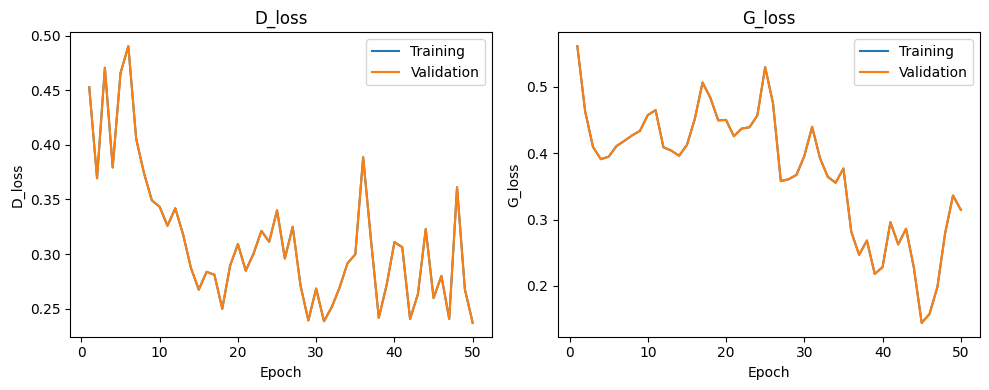

In [9]:
def plot_metrics(history, metrics):
    epoch_cnt = range(1, len(history[metrics[0]]) + 1)
    metrics_cnt = len(metrics)
    plt.figure(figsize=(10, 4))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, metrics_cnt, i)
        plt.plot(epoch_cnt, history[metric], label='Training')
        plt.plot(epoch_cnt, history[f'{metric}'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(model_trained.history, ['d_loss', 'g_loss'])

#### Generate images / Kaggle Submission
Use the trained model to generate fake images. Save result for Kaggle submission.

In [10]:
new_img_path = './images/'
os.makedirs(new_img_path, exist_ok=True)

for i in range(7500):
    prediction = generator(tf.random.normal(((1, 16, 16, 256))), training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(f"{new_img_path}{i}.jpg")

## Conclusion
The created DCGAN model has a generator with a total of 237,779 parameters using dense and convolutional layers with leaky ReLU activations, while the discriminator has 29,289 parameters with convolutional layers, batch normalization and dropout as well as Adam optimizer and binary cross-entropy loss function for improved performance. The training logs indicate that the discriminator loss steadily decreases, reaching a mean value of aprox 31%, while the generator loss fluctuates throughout training. A lower and fluctuating discriminator loss suggests that it is still not effective at distinguishing between real and generated samples. Additionally the fluctuating generator loss may indicate challenges in generating high-quality samples consistently.

To enhance the model several improvements could be explored such as hyperparameter tuning, trying different architectures and consideration of other regularization techniques. Additionally experimenting with different optimizers or learning rate schedules may achieve better stability and convergence during training.